

CatsDogs
Cats and Dogs binary classification using Pytorch, its a baseline CNN model. In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat. This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.

Link -->> https://www.kaggle.com/c/dogs-vs-cats

In [5]:
import numpy as np 
import pandas as pd 
import os
import glob
import torch
import zipfile
import matplotlib.pyplot as plt 
import torchvision
from torchvision.utils import make_grid 
from torchvision.models import resnet50 
from sklearn.model_selection import train_test_split 
import torch.nn as nn 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset 
from torchvision.datasets import ImageFolder
import torch.optim as optim 
from PIL import Image

torch.manual_seed(42)

##  Data

In [2]:


train_file = '/home/db/jupyter_projects/CatsDogs/train'
test_file = '/home/db/jupyter_projects/CatsDogs/test'

train_list = glob.glob(os.path.join(train_file,'*.jpg')) # Get list of all jpg files/dirs in data folder trian_dir
test_list = glob.glob(os.path.join(test_file, '*.jpg'))

In [3]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [4]:
print(os.listdir(train_file)[:5])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']


## Data visualization

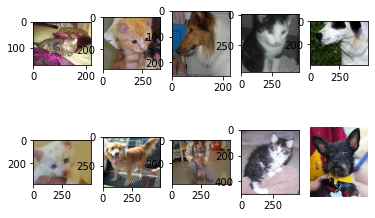

In [5]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [6]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device : {device}.")

Training on device : cuda.


In [7]:
label = [path.split('/')[-1].split('.')[0] for path in train_list]

In [8]:
print(type(label))

<class 'list'>


In [9]:
train_list[6071].split('/')[-1].split('.')[0]

'cat'

## Data split

In [10]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [11]:
print(len(train_list))
print(len(val_list))

20000
5000


## Data Augumentation

In [12]:

train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomCrop(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToTensor()
    ])


## Datasets and Dataloaders

In [13]:
class dataset(torch.utils.data.Dataset):
   
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label


In [14]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [15]:
trainloader = torch.utils.data.DataLoader(dataset = train_data, batch_size=8, shuffle=True )
testloader = torch.utils.data.DataLoader(dataset = test_data, batch_size=18, shuffle=False)
validloader = torch.utils.data.DataLoader(dataset = val_data, batch_size=8, shuffle=False)

## Data visualization

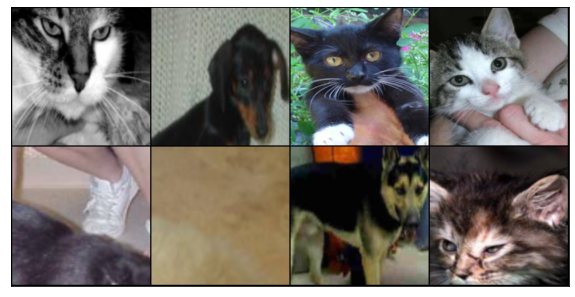

In [16]:
for images, labels in trainloader:
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [17]:
print(len(validloader))
print(len(trainloader))
print(len(testloader))

625
2500
695


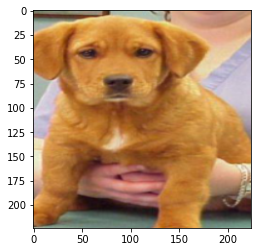

In [18]:
img = next(iter(trainloader))[0][0]
plt.imshow(transforms.ToPILImage()(img))

In [19]:
print(f"Train data: {len(train_data)}, Train loader: {len(trainloader)}")


Train data: 20000, Train loader: 2500


In [20]:
print(f"Val data: {len(val_data)}, Val loader: {len(validloader)}")

Val data: 5000, Val loader: 625


In [21]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

## TrainingLoop

In [22]:
import datetime

def TrainingLoop (epoch, model, loss_fn, optimizer, trainloader ):
     for epoch in range(1, epoch+1):
         epoch_loss = 0
         train_correct = 0
         train_total = 0
         for data, label in trainloader:
            data = data.to(device)
            label = label.to(device)
        
            output = model(data)
            loss = loss_fn(output, label)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            epoch_loss += loss.item()
            _,tpredicted = torch.max(output, dim=1)
            train_total += label.shape[0]
            train_correct += int((tpredicted == label).sum())
         if epoch == 1 or epoch %10 == 0:
            print(f"Loss in epoch {epoch} : {epoch_loss/len(trainloader)} : date and time : {datetime.datetime.now()}: Got {train_correct} / {train_total} with train accuracy of :{float(train_correct) / float(train_total) * 100:.2f}")
    
    
         with torch.no_grad():
              valid_loss = 0
              correct = 0
              total = 0
              for data, label in validloader:
                  data = data.to(device=device)
                  label = label.to(device=device)
            ## Forward Pass
                  val_output = model(data)
                  val_loss = loss_fn(val_output, label)
                  valid_loss += val_loss.item()
                  _, predicted = torch.max(val_output, dim=1)
                  total += label.shape[0]
                  correct += int((predicted == label).sum())
              if epoch == 1 or epoch %10 == 0:
               print(
                   f"Loss in Valid epoch {epoch} : {valid_loss/len(validloader)} : Got {correct} / {total} with valid accuracy of :{float(correct) / float(total) * 100:.2f}")

## Transfer learning Resnet50

In [23]:
from torchvision.models import resnet50
Net = resnet50(pretrained = True)

# Modifying Head of the classifier

Net.fc = nn.Sequential(
    nn.Dropout(0.3), #dropout incoming last convnet's few features
    nn.Linear(2048, 2)
)

In [24]:

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
model =Net.to(device=device)
model.train()
optimizer = optim.SGD(params = model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [25]:
TrainingLoop(
    epoch=10,
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    trainloader=trainloader,

)

Loss in epoch 1 : 0.2243860801840201 : date and time : 2022-04-20 18:46:24.904942: Got 18168 / 20000 with train accuracy of :90.84
Loss in Valid epoch 1 : 0.16517693873271347 : Got 4679 / 5000 with valid accuracy of :93.58
Loss in epoch 10 : 0.08322408119685715 : date and time : 2022-04-20 19:32:00.444477: Got 19380 / 20000 with train accuracy of :96.90
Loss in Valid epoch 10 : 0.08550401275092735 : Got 4844 / 5000 with valid accuracy of :96.88


## Save and Load the model

In [26]:
#torch.save(model.state_dict(), "/home/db/jupyter_projects/CatsDogs/catsdog_resnet50.pt")

In [27]:
model = Net.to(device="cpu")
#model.load_state_dict(torch.load("/home/db/jupyter_projects/CatsDogs/catsdog_resnet50.pt"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Test data evaluation

In [28]:
dog_probs = []
model.eval()
with torch.no_grad():
    for data, fileid in testloader:
        data = data.to(device="cpu")
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(list(fileid), preds_list))
    

In [29]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[('1', 0.9999994039535522),
 ('2', 0.9999940395355225),
 ('3', 0.9999994039535522),
 ('4', 0.9999840259552002),
 ('5', 0.00019343584426678717),
 ('6', 0.016241667792201042),
 ('7', 1.916393102874281e-06),
 ('8', 0.00026104168500751257),
 ('9', 0.1185067892074585),
 ('10', 0.002757874084636569),
 ('11', 0.00012565846554934978),
 ('12', 0.9998449087142944),
 ('13', 4.2429950553923845e-05),
 ('14', 0.0030290100257843733),
 ('15', 0.008758783340454102),
 ('16', 0.00013223804126027972),
 ('17', 0.9998918771743774),
 ('18', 0.999984622001648),
 ('19', 0.0003455727710388601),
 ('20', 0.08260627090930939),
 ('21', 0.9999876022338867),
 ('22', 0.006386692635715008),
 ('23', 0.9999973773956299),
 ('24', 0.9914804697036743),
 ('25', 1.4259492672863416e-05),
 ('26', 0.9997708201408386),
 ('27', 0.9999988079071045),
 ('28', 9.899798669721349e-08),
 ('29', 0.19695347547531128),
 ('30', 0.9804758429527283),
 ('31', 0.9999924898147583),
 ('32', 0.060342513024806976),
 ('33', 0.9999809265136719),
 ('34